In [1]:
import os
import zipfile
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

import pickle

# SQL Data
> - Unzipping file (im.db.zip), making a connection, conn and assigning a cursor
> - Opening file as a dataframe
> - Creating a single table with relevant data for us to use:

In [2]:
# Check if 'im.db' exists, unzip if it doesn't
if not os.path.exists('../zippedData/im.db'):
    with zipfile.ZipFile('../zippedData/im.db.zip', 'r') as zip_ref:
        zip_ref.extractall('../zippedData')

# Connect to the SQLite database
conn = sqlite3.connect('../zippedData/im.db')

In [3]:
cursor = conn.cursor()

In [4]:
pd.read_sql("""
  SELECT *
  FROM sqlite_master  
  """, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


# SQL Data Cleaning and Joining
> > - Movie_ID, Genres, Avg_Rating, Num_Votes, Region, Category, Artist_Name, Screen_Time, and Movie_Title
> > - Where region is United States with Number of votes greater than 1000 and Average rating is 6 and above
> > - Removed all duplicates from our joining point primary key Movie_ID and foreign Key Person_ID

In [5]:
#Select relevant data for computation and set certain cleaning papmeters such as region = US, Death_year Is null and avgrating >=6
final_q = pd.read_sql("""
SELECT mb.movie_id, mb.genres, mr.averagerating AS avg_ratings, mr.numvotes AS num_votes, mk.region, 
pr.category, p.primary_name AS artist_name, mb.runtime_minutes AS screen_time, mb.primary_title AS movie_title, p.death_year
FROM movie_basics mb
JOIN movie_akas mk ON mk.movie_id = mb.movie_id
JOIN movie_ratings mr ON mr.movie_id = mb.movie_id
JOIN principals pr ON pr.movie_id = mb.movie_id
JOIN persons p ON p.person_id = pr.person_id
WHERE mk.region != 'None'
AND p.death_year IS NULL
;""", conn)
#More cleaning using pandas, dropped duplicates, set the defining catagories and dropped missing/empty values from Genre
final_q = final_q.drop_duplicates(subset=['movie_id'])
# Removing duplicate movie names
final_q = final_q.drop_duplicates(subset=['movie_title'])
final_q = final_q.dropna(subset=['genres'])
categories_of_interest = ['actor', 'actress', 'writer', 'director', 'producer']
final_q = final_q[final_q['category'].isin(categories_of_interest)]
#Created a weighted average for rating
final_q['weighted_avg'] = (final_q['avg_ratings'] * final_q['num_votes']) / final_q['num_votes'].sum()
final_q

,movie_id,genres,avg_ratings,num_votes,region,category,artist_name,screen_time,movie_title,death_year,weighted_avg
0,tt0369610,"Action,Adventure,Sci-Fi",7.0,539338,BG,producer,Patrick Crowley,124.0,Jurassic World,None,1.666936e-02
423,tt0381957,Drama,7.6,23,GB,actor,Derek Jacobi,92.0,Cloud Cuckoo Land,None,7.717939e-07
433,tt0401729,"Action,Adventure,Sci-Fi",6.6,241792,UA,actor,Willem Dafoe,132.0,John Carter,None,7.046051e-03
750,tt10084780,"Drama,Romance",8.3,30,IN,director,Sateesh Chandra Nadella,NaN,Vinara sodara veera kumara,None,1.099409e-06
760,tt1014759,"Adventure,Family,Fantasy",6.5,358813,IE,actor,Johnny Depp,108.0,Alice in Wonderland,None,1.029773e-02
...,...,...,...,...,...,...,...,...,...,...,...
1992082,tt9593792,Horror,6.1,39,TH,director,Mate Yimsomboon,NaN,Ghost Wife,None,1.050399e-06
1992100,tt9644084,Documentary,5.2,5,DE,director,Uli M. Schüppel,95.0,Der Atem,None,1.147977e-07
1992120,tt9657946,Drama,6.0,16,XWW,actor,Marcelo Di Souza,90.0,Homing,None,4.238685e-07
1992144,tt9726638,"Action,Adventure,Comedy",6.0,6,CN,actress,Carman Lee,90.0,Monkey King: The Volcano,None,1.589507e-07


# CSV Files
> - Uploaded Zipped csv files and printed columns
> - Dropped Not needed columns from each file
> - Decide to also drop data with more that 50% of value missing

In [6]:
# Reading the movie info data
movie_info = pd.read_csv('../zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')

# Dropping unnecessary columns from movie info data
movie_info_drop = ['box_office', 'currency', 'dvd_date', 'studio']
movie_info = movie_info.drop(columns=movie_info_drop)

# Printing the columns of movie info data
print("movie_info columns:")
print(list(movie_info.columns))
print()

# Reading the movie gross data
movie_gross = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')

# Printing the columns of movie gross data
print("movie_gross columns:")
print(list(movie_gross.columns))
print()

# Reading the movie budget data
movie_budget = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')

# Printing the columns of movie budget data
print("movie_budget columns:")
print(list(movie_budget.columns))
print()

# Reading the movie reviews data
movie_reviews = pd.read_csv('../zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='latin-1')

# Dropping unnecessary column from movie reviews data
movie_review_drop = ['rating']
movie_reviews = movie_reviews.drop(columns=movie_review_drop)

# Printing the columns of movie reviews data
print("movie_reviews columns:")
print(list(movie_reviews.columns))
print()

# Reading the tmdb movie data
tmbd_movie = pd.read_csv('../zippedData/tmdb.movies.csv.gz')

# Printing the columns of tmdb movie data
print("tmbd_movie columns:")
print(list(tmbd_movie.columns))
print()

movie_info columns:
['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'runtime']

movie_gross columns:
['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

movie_budget columns:
['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

movie_reviews columns:
['id', 'review', 'fresh', 'critic', 'top_critic', 'publisher', 'date']

tmbd_movie columns:
['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']



# Movie Budget Cleaning
> - After analysing the CSV, we decided to use the Movie Budge data
> - We cleaned the data removing comma's and $ sign, assigning the column as integer
> - We removed duplicated from movies column to ease merging with SQL data
> - Calculated needed number to compute profit and budget better, and created columns for each such as ROI

In [7]:
# Converting release_date column to datetime format
movie_budget["release_date"] = pd.to_datetime(movie_budget["release_date"])

# Extracting release year and month from release_date
movie_budget["release_year"] = movie_budget["release_date"].dt.year
movie_budget["release_month"] = movie_budget["release_date"].dt.month

# Removing commas and dollar signs, and converting production_budget, domestic_gross, and worldwide_gross columns to integer format
movie_budget["production_budget"] = movie_budget["production_budget"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["domestic_gross"] = movie_budget["domestic_gross"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["worldwide_gross"] = movie_budget["worldwide_gross"].str.replace(",", "").str.replace("$", "").astype("int64")

movie_budget["production_budget"] = movie_budget["production_budget"] / 1000000
movie_budget["domestic_gross"] = movie_budget["domestic_gross"] / 1000000
movie_budget["worldwide_gross"] = movie_budget["worldwide_gross"] / 1000000

# Removing duplicate movie names 
movie_budget = movie_budget.drop_duplicates(subset=['movie'])

# Removing rows where worldwide_gross is 0
movie_budget = movie_budget[movie_budget['worldwide_gross'] != 0]

# Calculating foreign_gross as the difference between worldwide_gross and domestic_gross
movie_budget["foreign_gross"] = movie_budget["worldwide_gross"] - movie_budget["domestic_gross"]

# Calculating total_profit as the difference between worldwide_gross and production_budget
movie_budget["total_profit"] = movie_budget["worldwide_gross"] - movie_budget["production_budget"]

# Calculating ROI (Return on Investment) as the ratio of worldwide_gross to production_budget multiplied by 100
movie_budget['roi'] = movie_budget['total_profit'] / movie_budget['production_budget']
movie_budget

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,foreign_gross,total_profit,roi
0,1,2009-12-18,Avatar,425.0000,760.507625,2776.345279,2009,12,2015.837654,2351.345279,5.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410.6000,241.063875,1045.663875,2011,5,804.600000,635.063875,1.546673
2,3,2019-06-07,Dark Phoenix,350.0000,42.762350,149.762350,2019,6,107.000000,-200.237650,-0.572108
3,4,2015-05-01,Avengers: Age of Ultron,330.6000,459.005868,1403.013963,2015,5,944.008095,1072.413963,3.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317.0000,620.181382,1316.721747,2017,12,696.540365,999.721747,3.153696
...,...,...,...,...,...,...,...,...,...,...,...
5775,76,2006-05-26,Cavite,0.0070,0.070071,0.071644,2006,5,0.001573,0.064644,9.234857
5776,77,2004-12-31,The Mongol King,0.0070,0.000900,0.000900,2004,12,0.000000,-0.006100,-0.871429
5778,79,1999-04-02,Following,0.0060,0.048482,0.240495,1999,4,0.192013,0.234495,39.082500
5779,80,2005-07-13,Return to the Land of Wonders,0.0050,0.001338,0.001338,2005,7,0.000000,-0.003662,-0.732400


In [8]:
import pandas as pd
from scipy import stats

upper_middle_range = stats.iqr(movie_budget['production_budget'], rng=(25, 75))

lower_middle_range = stats.iqr(movie_budget['production_budget'], rng=(25, 50))

lowest_range = stats.iqr(movie_budget['production_budget'], rng=(0, 25))

print("Upper Middle Range:", upper_middle_range)
print("Lower Middle Range:", lower_middle_range)
print("Lowest Range:", lowest_range)

Upper Middle Range: 36.0
Lower Middle Range: 13.100000000000001
Lowest Range: 5.9989


# Merge Movie_Budget with Merged_SQL

In [9]:
# merge movie_basics and movie_budget on movie and primary_title
final_data = pd.merge(final_q, movie_budget, left_on="movie_title", right_on="movie", how="inner")
final_data

,movie_id,genres,avg_ratings,num_votes,region,category,artist_name,screen_time,movie_title,death_year,...,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,foreign_gross,total_profit,roi
0,tt0369610,"Action,Adventure,Sci-Fi",7.0,539338,BG,producer,Patrick Crowley,124.0,Jurassic World,None,...,2015-06-12,Jurassic World,215.0,652.270625,1648.854864,2015,6,996.584239,1433.854864,6.669092
1,tt0401729,"Action,Adventure,Sci-Fi",6.6,241792,UA,actor,Willem Dafoe,132.0,John Carter,None,...,2012-03-09,John Carter,275.0,73.058679,282.778100,2012,3,209.719421,7.778100,0.028284
2,tt1014759,"Adventure,Family,Fantasy",6.5,358813,IE,actor,Johnny Depp,108.0,Alice in Wonderland,None,...,2010-03-05,Alice in Wonderland,200.0,334.191110,1025.491110,2010,3,691.300000,825.491110,4.127456
3,tt1194173,"Action,Adventure,Thriller",6.7,268678,RS,actor,Scott Glenn,135.0,The Bourne Legacy,None,...,2012-08-10,The Bourne Legacy,125.0,113.203870,280.355920,2012,8,167.152050,155.355920,1.242847
4,tt1219289,"Mystery,Sci-Fi,Thriller",7.4,492490,AR,actor,Robert De Niro,105.0,Limitless,None,...,2011-03-18,Limitless,27.0,79.249455,155.564919,2011,3,76.315464,128.564919,4.761664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,tt3829266,"Action,Adventure,Sci-Fi",5.4,94888,LT,director,Shane Black,107.0,The Predator,None,...,2018-09-14,The Predator,88.0,51.024708,159.487563,2018,9,108.462855,71.487563,0.812359
1713,tt4651520,Comedy,6.2,100952,UA,actress,Christina Applegate,100.0,Bad Moms,None,...,2016-07-29,Bad Moms,20.0,113.257297,180.998716,2016,7,67.741419,160.998716,8.049936
1714,tt5462602,"Comedy,Drama,Romance",7.6,104008,NO,actress,Holly Hunter,120.0,The Big Sick,None,...,2017-06-23,The Big Sick,5.0,42.872467,53.972860,2017,6,11.100393,48.972860,9.794572
1715,tt5649108,"Comedy,Crime,Drama",6.7,25098,FR,producer,Nat Faxon,92.0,Thoroughbreds,None,...,2018-03-09,Thoroughbreds,5.0,3.072605,3.187302,2018,3,0.114697,-1.812698,-0.362540


> - Seperating and analysing the Genre column
> - We exploded the genre column for each comma entry to be represented
> - We found the 5 most appearing Genre with highest ROI

# Sample Testing T-Test
> - H_0 = The population (movie_budget) data and the final_data don't have significant ROI mean difference 
> - H_1 = The population (movie_budget) data and the final_data have significant ROI mean difference  
> > - We analyze at significance level alpha = 0.05
> > - Since p-vaue (0.20767657995377473) is greater than our alpha we fail to reject the null
> > - Meaning there isn't enough evidence to suggest a significant difference between our final data and original population

In [10]:
# Extract the ROI column from each DataFrame
initial_roi = movie_budget['roi']
joined_roi = final_data['roi']

# Perform the two-sample t-test
t_statistic, p_value = stats.ttest_ind(initial_roi, joined_roi, equal_var=True)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 1.2600955824262787
P-Value: 0.20767657995377428


In [11]:
final_data.to_csv('final_data.csv', index = False)

# Data Visualizations

In [12]:
# Convert 'genres' to string and then split
final_data['genres'] = final_data['genres'].astype(str).str.split(',')
# Explode the 'genres' column
final_data_exp = final_data.explode('genres')

In [13]:
directors = final_data_exp[(final_data_exp['category'] == 'director') & 
                           (final_data_exp['genres'].str.contains('Horror|Thriller|Mystery')) &
                           (final_data_exp['avg_ratings'] >= 7) &
                           (final_data_exp['num_votes'] >= 9000)]

# Sort the directors by ratings in descending order
directors = directors.sort_values(by='avg_ratings', ascending=False)

# Print the director names with ratings
print("To 5 Directors:")
for index, row in directors.iterrows():
    print(row['artist_name'])

To 5 Directors:
David Fincher
John Madden
Kathryn Bigelow
Derek Cianfrance
Oliver Stone


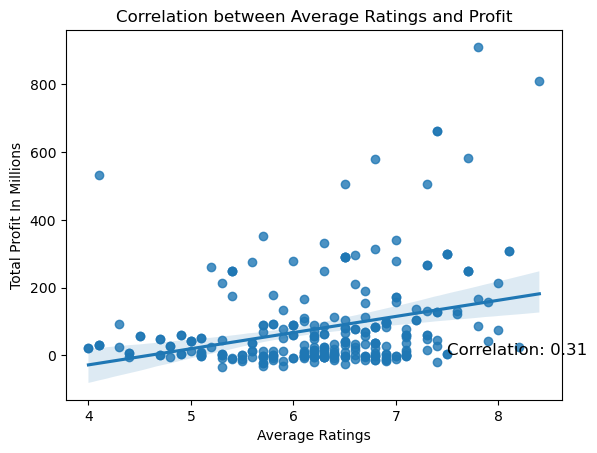

In [14]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Actors_Actress = final_data_exp[(final_data_exp['category'].isin(['actor', 'actress','writer'])) & 
                        (final_data_exp['genres'].str.contains('Horror|Mystery|Thriller')) &
                               (final_data_exp['avg_ratings']) &
                               (final_data_exp['release_date'] >= '2011-01-01') &
                               (final_data_exp['num_votes'] >= 9000)]

# Sort the actors and actresses by average ratings in descending order
Actors_Actress = Actors_Actress.sort_values(by='avg_ratings', ascending=False)

# Calculate the correlation between average ratings and ROI
correlation = np.corrcoef(Actors_Actress['avg_ratings'], Actors_Actress['total_profit'])[0, 1]

sns.regplot(x=Actors_Actress['avg_ratings'], y=Actors_Actress['total_profit'])
plt.xlabel('Average Ratings')
plt.ylabel('Total Profit In Millions')
plt.title('Correlation between Average Ratings and Profit')

plt.text(7.5, 0.2, f'Correlation: {correlation:.2f}', fontsize=12)

plt.show()

In [15]:
Actors_Actress = final_data_exp[(final_data_exp['category'].isin(['actor', 'actress'])) & 
                               (final_data_exp['genres'].str.contains('Horror|Mystery')) &
                               (final_data_exp['avg_ratings'] >= 7.5) &
                               (final_data_exp['release_date'] >= '2011-01-01') &
                               (final_data_exp['num_votes'] >= 15000)]

# Sort the actors and actresses by average ratings in descending order
Actors_Actress = Actors_Actress.sort_values(by='avg_ratings', ascending=False)['artist_name'].unique()

# Print the actor and actress names with average ratings
print("Actors and Actresses:")
for name in Actors_Actress:
    print(name)

Actors and Actresses:
Ben Affleck
Harrison Ford
Forest Whitaker
Samuel L. Jackson
Catherine Keener
John C. Reilly
Lili Taylor


In [16]:
directors = final_data_exp[(final_data_exp['category'] == 'director') & 
                           (final_data_exp['genres'].str.contains('Horror|Thriller|Mystery')) &
                           (final_data_exp['avg_ratings'] >= 6.5)& 
                           (final_data_exp['num_votes'] >= 9000)]

# Sort the directors by ratings in descending order
directors = directors.sort_values(by='avg_ratings', ascending=False)

# Print the director names with ratings
print("Directors:")
for index, row in directors.iterrows():
    print(row['artist_name'], "-", row['avg_ratings'])

Directors:
David Fincher - 7.8
John Madden - 7.5
Kathryn Bigelow - 7.4
Derek Cianfrance - 7.3
Oliver Stone - 7.3
Danny Boyle - 6.9
Roland Emmerich - 6.9
Lasse Hallström - 6.7
Oliver Stone - 6.5


In [17]:
Actors_Actress = final_data_exp[(final_data_exp['category'].isin(['actor','actress']))& 
                           (final_data_exp['genres'].str.contains('Horror|Thriller|Mystery'))&
                           (final_data_exp['avg_ratings'] >= 7.5) &
                           (final_data_exp['num_votes'] >= 9000)]

# Get the unique names from the 'artist_name' column
Actors_Actress = Actors_Actress['artist_name'].unique()


print("Actors and Actress:")
for name in Actors_Actress:
    print(name)

Actors and Actress:
Leonardo DiCaprio
Natalie Portman
Ben Affleck
John C. Reilly
Tom Hanks
Gary Oldman
Rene Russo
Javier Bardem
Lubna Azabal
Matthew Goode
Lili Taylor
Forest Whitaker
Samuel L. Jackson
Sandra Bullock
Ewan McGregor
Harrison Ford
Sean Bridgers
Catherine Keener


In [18]:
Writers = final_data_exp[(final_data_exp['category'].isin(['writer'])) & 
                           (final_data_exp['genres'].str.contains('Horror|Thriller'))&
                           (final_data_exp['avg_ratings'] >= 6.5)]

# Get the unique names from the 'artist_name' column
Writers = Writers.sort_values(by='avg_ratings', ascending=False)['artist_name'].unique()

# Print the director names
print("Best Writers:")
for name in Writers:
    print(name)

Best Writers:
Stephen King
Dario Argento
Phil Hay
John Carpenter
Colin Bateman
Sam Raimi


In [19]:
import pandas as pd
from scipy import stats

upper_middle_range = stats.iqr(final_data['production_budget'], rng=(25, 75))

lower_middle_range = stats.iqr(final_data['production_budget'], rng=(25, 50))

lowest_range = stats.iqr(final_data['production_budget'], rng=(0, 25))

print("Upper Middle Range:", upper_middle_range)
print("Lower Middle Range:", lower_middle_range)
print("Lowest Range:", lowest_range)

Upper Middle Range: 42.0
Lower Middle Range: 14.5
Lowest Range: 7.991
